# IMPORTS

In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

import os
import time
import matplotlib.pyplot as plt

from modules.utils import *
%matplotlib inline

In [2]:
#SEED

seed = 1234
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
#GPU CHECK

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

# RAW DATA

In [4]:
article_directory = '../datasets/train-articles/'
label_directory = '../datasets/train-labels-task1-span-identification/'

In [5]:
article_fnames = os.listdir(article_directory)
article_ids = [int(fname[7:16]) for fname in article_fnames]

In [6]:
data_raw = [read_article(idx) for idx in article_ids]

# VOCABULARY BUILDING

In [7]:
vocab_list = []
exceptions = []
for i in range(len(data_raw)):
    text = data_raw[i][0]
    wordlist = getWordSpans(text)
    try:
        for word in wordlist:
            if text[word[0]:word[1]] not in vocab_list:
                vocab_list.append(text[word[0]:word[1]])
    except:
        exceptions.append(i)
        print(i, " has an error")

In [8]:
vocab_dict = {k: v+2 for v, k in enumerate(vocab_list)}

In [9]:
#PADDING AND OUT-OF-VOCABULARY

pad_id = 0
oov_id = 1

In [10]:
vocab_dict['<PAD>'] = pad_id
vocab_dict['<OOV>'] = oov_id

In [11]:
vocab_length = len(vocab_dict)
vocab_length

21700

# DATASET

In [12]:
#GENERATING WORK TOKEN SEQUENCES FOR LSTM TRAINING

max_len = 8

X_right = []
X_left = []
y = []

for idx in article_ids:   
    words, labels = getLabeledWords(idx)
    word_tokens = [vocab_dict[word] for word in words]
    
    for i in range(len(word_tokens)):
        y.append(labels[i])
        
        x_r = word_tokens[i:]
        x_l = word_tokens[:i+1]
        
        if len(x_r)>max_len:
            x_r = x_r[:max_len]
        elif len(x_r)<max_len:
            x_r = x_r + [pad_id]*(max_len-len(x_r))
        
        if len(x_l)>max_len:
            x_l = x_l[-max_len:]
        elif len(x_l)<max_len:
            x_l = [pad_id]*(max_len-len(x_l)) + x_l
            
        X_right.append(x_r[::-1])
        X_left.append(x_l)

In [13]:
#ONE HOT ENCODINGS TOKENS DATASET

class OneHotTdLstmDataset(Dataset):
    def __init__(self, x_right_seqs, x_left_seqs, y, vocab_length, transform=None):
        self.x_right_seqs = x_right_seqs
        self.x_left_seqs = x_left_seqs
        self.y = y
        self.vocab_length = vocab_length
        self.transform = transform
    
    def __len__(self):
        return len(self.x_right_seqs)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        x_r, x_l = self.x_right_seqs[idx], self.x_left_seqs[idx]
        x_r_one_hot, x_l_one_hot = np.zeros((len(x_r), self.vocab_length)), np.zeros((len(x_l), self.vocab_length))
        
        rows_r, cols_r = zip(*[(i, x_r[i]) for i in range(len(x_r))])
        rows_l, cols_l = zip(*[(i, x_l[i]) for i in range(len(x_l))])
 
        x_r_one_hot[rows_r, cols_r] = np.ones(len(x_r))
        x_l_one_hot[rows_l, cols_l] = np.ones(len(x_l))
        
        x_r_one_hot = torch.tensor(x_r_one_hot)
        x_l_one_hot = torch.tensor(x_l_one_hot)
        y_ = torch.tensor(self.y[idx])
        
        return x_r_one_hot, x_l_one_hot, y_

In [14]:
#ITERATORS

train_dataset = OneHotTdLstmDataset(X_right, X_left, y, vocab_length)
train_loader = DataLoader(train_dataset, batch_size=32,
                        shuffle=True, num_workers=4)

# MODEL

In [15]:
#TD-LSTM

class WordTDLSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super(WordTDLSTM, self).__init__()
        
        #Input Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        #Defining Layers
        self.lstm_l = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lstm_r = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, sequence_r, sequence_l):
        #LSTM Outputs
        __, (lstm_r_out, _) = self.lstm_r(sequence_r)                 #Right LSTM output
        __, (lstm_l_out, _) = self.lstm_l(sequence_l)                 #Left LSTM output

        #FC Layer
        fc_input = torch.cat((lstm_r_out, lstm_l_out), dim=2)    #Concatenating outputs from last cells of both LSTMs
        fc_input = fc_input.reshape(fc_input.shape[1], fc_input.shape[2])
        out = self.fc(fc_input)                                  #Final sigmoid output
        out = self.sigmoid(out)
        
        return out

In [16]:
model = WordTDLSTM(vocab_length, 128)
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-5)
criterion = nn.BCELoss()

In [18]:
#TRAINING

epochs = 3
train_loss = []
start_time = time.time()

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs_r, inputs_l, labels = data
        inputs_r, inputs_l, labels = inputs_r.to(device), inputs_l.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs_r.float(), inputs_l.float())
        loss = criterion(outputs.flatten(), labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        
        if i % 1000 == 999:    # print every 1000 mini-batches
            print('[%d, %5d] loss: %.3f time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000, time.time()-start_time))
            train_loss.append(running_loss / 1000)
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 0.384 time: 99.667
[1,  2000] loss: 0.327 time: 199.273
[1,  3000] loss: 0.301 time: 296.134
[1,  4000] loss: 0.277 time: 396.725
[1,  5000] loss: 0.259 time: 493.538
[1,  6000] loss: 0.247 time: 589.614
[1,  7000] loss: 0.236 time: 684.945
[1,  8000] loss: 0.229 time: 782.281
[1,  9000] loss: 0.215 time: 878.985
[1, 10000] loss: 0.206 time: 976.394
[2,  1000] loss: 0.147 time: 1154.578
[2,  2000] loss: 0.152 time: 1249.073
[2,  3000] loss: 0.145 time: 1344.483
[2,  4000] loss: 0.143 time: 1439.261
[2,  5000] loss: 0.149 time: 1538.072
[2,  6000] loss: 0.137 time: 1636.914
[2,  7000] loss: 0.133 time: 1732.190
[2,  8000] loss: 0.132 time: 1826.736
[2,  9000] loss: 0.129 time: 1921.122
[2, 10000] loss: 0.122 time: 2016.391
[3,  1000] loss: 0.075 time: 2194.228
[3,  2000] loss: 0.079 time: 2289.694
[3,  3000] loss: 0.078 time: 2384.602
[3,  4000] loss: 0.084 time: 2479.854
[3,  5000] loss: 0.080 time: 2574.122
[3,  6000] loss: 0.081 time: 2669.532
[3,  7000] loss: 0.081 

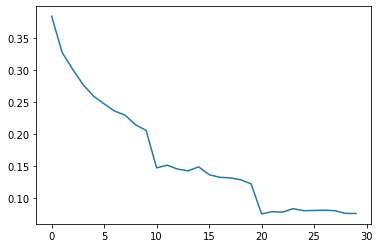

In [19]:
plt.plot(train_loss)

In [20]:
torch.save(model, './WordTDLSTM_one_hot_23_12_19.pth')

/home/rajaswa/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type WordTDLSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rajaswa/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rajaswa/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/rajaswa/.local/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sigmoid. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be